In [10]:
import sys
import os
sys.path.append('..')


# Prepare model

In [11]:
import torch
from comic_ocr.models import localization
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count
from comic_ocr.models.localization.conv_unet.conv_unet import BaselineConvUnet

model_name = 'localization_base'
model_path = get_path_project_dir(f'data/output/models/{model_name}.bin')


model = BaselineConvUnet()
# model = localization.load_model(model_path)

In [12]:
print('- preferred_image_size:', model.preferred_image_size)
print('- get_total_parameters_count', get_total_parameters_count(model))

dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = localization.LocalizationDataset\
    .load_line_annotated_manga_dataset(dataset_example_path)

localization.calculate_high_level_metrics(model, dataset_example)

- preferred_image_size: (500, 500)
- get_total_parameters_count 197986


{'sample_size': 4,
 'total_line_level_true_positive': 0,
 'total_line_level_false_positive': 5,
 'total_line_level_false_negative': 67,
 'line_level_precision': 0.0,
 'line_level_recall': 0.0,
 'line_level_accuracy': 0.0}

# Prepare Datasets

In [13]:
from comic_ocr.utils.ploting import show_images

dataset_example 5


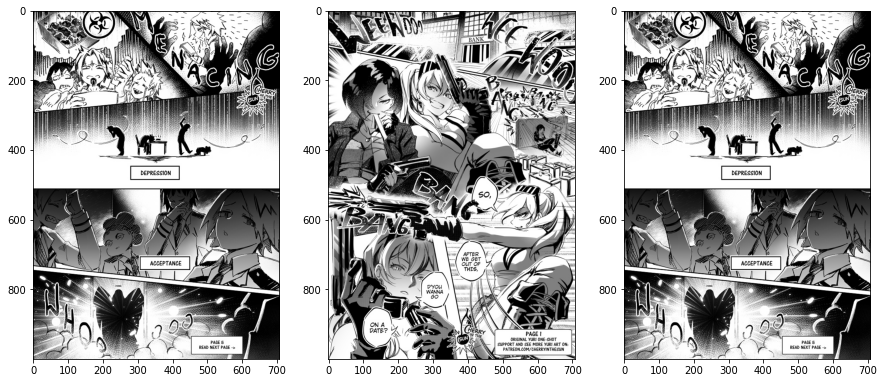

In [14]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = localization.LocalizationDataset.\
    load_line_annotated_manga_dataset(dataset_example_path)

print('dataset_example', len(dataset_example))


show_images([
    dataset_example.get_image(0), 
    dataset_example.get_image(1), 
    dataset_example.get_image(-5)
])

dataset_generated 500


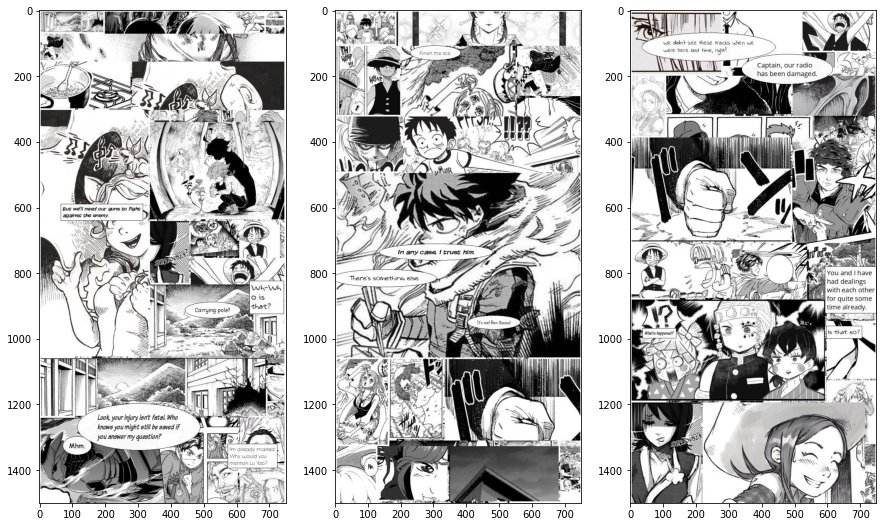

In [15]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = localization.LocalizationDataset.\
    load_generated_manga_dataset(dataset_generated_path)

print('dataset_generated', len(dataset_generated))
show_images([
    dataset_generated.get_image(0), 
    dataset_generated.get_image(1), 
    dataset_generated.get_image(-1)
])

dataset_annotated 22
dataset_annotated_no_text 49


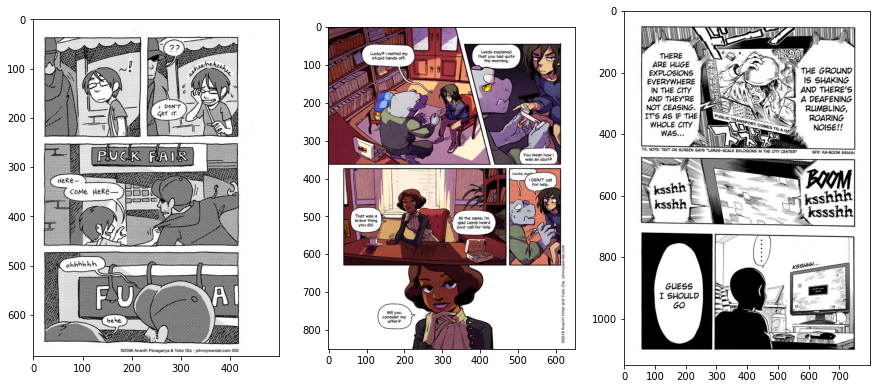

In [16]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = localization.LocalizationDataset.\
    load_line_annotated_manga_dataset(dataset_annotated_path)
print('dataset_annotated', len(dataset_annotated))

dataset_annotated_no_text_path = get_path_project_dir('data/manga_line_annotated_no_text')
dataset_annotated_no_text = localization.LocalizationDataset.\
    load_line_annotated_manga_dataset(dataset_annotated_no_text_path)
print('dataset_annotated_no_text', len(dataset_annotated_no_text))

dataset_annotated = localization.LocalizationDataset.merge(
    dataset_annotated, dataset_annotated_no_text)
show_images([
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(-1)
])

## Train/Validation Datasets

Note: We include the `dataset_example` in both training and validation to make the model does well enough to pass unittests. This is not theoritically correct way to train the model.

In [17]:
import random
random.seed('abdc')
dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()
dataset_example = dataset_example.shuffle()

# Validation Dataset (annotated + example)
validation_dataset = localization.LocalizationDataset.merge(
    dataset_example,
    dataset_annotated.subset(to_idx=35)
).shuffle()

# Training Dataset (generated + annotated + example)
training_dataset = localization.LocalizationDataset.merge(
    dataset_annotated.subset(from_idx=35).repeat(5),
    dataset_generated.subset(from_idx=0),
)

training_dataset = localization.LocalizationDataset.merge(
    training_dataset,
    dataset_example.repeat(10),
).shuffle()

training_dataset = localization.LocalizationDatasetWithAugmentation.\
    of_dataset(training_dataset, batch_image_size=model.preferred_image_size, 
               enable_color_jitter=True, color_jitter_brightness=0.5, contrast=0.5)

print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 40
training_dataset 730


# Training

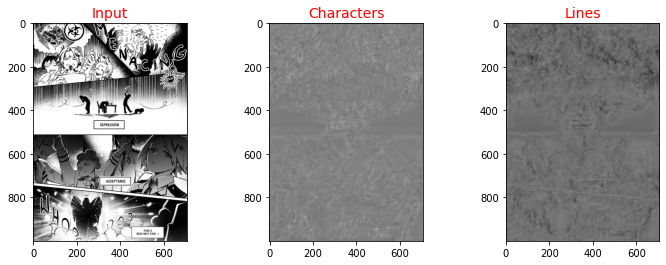

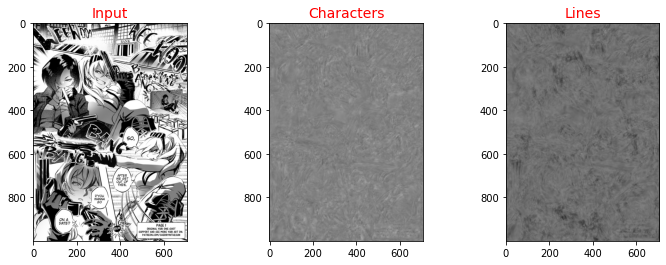

In [21]:
from comic_ocr.models.localization import train
from comic_ocr.models.localization.localization_model import WeightedDiceLoss
from comic_ocr.models.localization.localization_model import WeightedBCEWithLogitsLoss
from comic_ocr.utils.ploting import plot_losses, plot_metrics, show_images
from torch import optim
from IPython.display import clear_output
from comic_ocr.utils.files import load_image

example_1 = load_image(get_path_project_dir('example/manga_annotated/normal_01.jpg'))
example_2 = load_image(get_path_project_dir('example/manga_annotated/normal_02.jpg'))

# Saving the model on increasing precision
save_model = train.callback_to_save_model_on_increasing_metric(
    model, model_path, 'line_level_precision')


def show_example(model, img):
    mask_char, mask_line = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line], 
        texts=['Input', 'Characters', 'Lines'], 
        figsize=(12, 4), num_col=3
    )

def save_and_report(step, train_metrics, validate_metrics):
    save_model(step, train_metrics, validate_metrics)
    clear_output()
    plot_metrics(metrics=[
        ('Training Losses', train_metrics['loss']),
        ('Validation Losses', validate_metrics['loss']),
        ('Line-level Precision', validate_metrics['line_level_precision']),
        ('Line-level Recall', validate_metrics['line_level_recall']),
    ], num_col=2, figsize=(10, 5))
    show_example(model, example_1)
    show_example(model, example_2)
    
show_example(model, example_1)
show_example(model, example_2)

In [22]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

<Figure size 720x360 with 0 Axes>

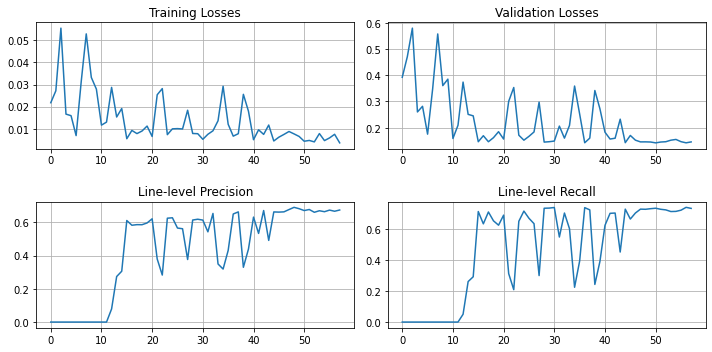

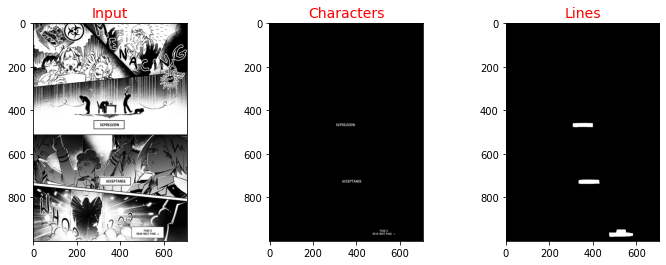

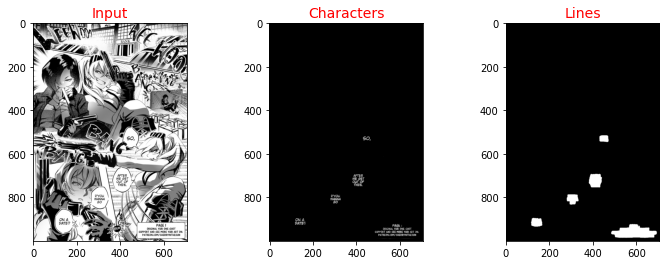

Epoch 39: 100%|██████████| 730/730 [00:29<00:00, 24.75it/s, current_batch_loss=0.0535]


In [23]:
_ = train.train(
    model_name, model,
          train_dataset=training_dataset,
          train_device=device,
          validate_dataset=validation_dataset,
          validate_device=device,
          update_callback=save_and_report,
          update_every_n=50,
          batch_size=10,
          train_epoch_count=40)

In [24]:
localization.calculate_high_level_metrics(model, dataset_annotated, device=device)

{'sample_size': 70,
 'total_line_level_true_positive': 1308,
 'total_line_level_false_positive': 816,
 'total_line_level_false_negative': 530,
 'line_level_precision': 0.615819209039548,
 'line_level_recall': 0.7116430903155604,
 'line_level_accuracy': 0.49284099472494347}

In [13]:
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
# loss_criterion_for_char = WeightedBCEWithLogitsLoss(weight=1.0).to(device)
# loss_criterion_for_line = WeightedDiceLoss(weight=0.1).to(device)

# _ = train.train(
#     model_name, model,
#           train_dataset=training_dataset,
#           train_device=device,
#           validate_dataset=validation_dataset,
#           validate_device=device,
#           update_callback=save_and_report,
#           loss_criterion_for_char=loss_criterion_for_char,
#           loss_criterion_for_line=loss_criterion_for_line,
#           optimizer=optimizer,
#           update_every_n=50,
#           batch_size=10,
#           train_epoch_count=10)

# Validation

In [25]:
from comic_ocr.models import localization

In [26]:
default_model = localization.load_model()
model = localization.load_model(model_path)


In [27]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = localization.LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_example_path)

localization.calculate_high_level_metrics(model, dataset_example, device=device)

{'sample_size': 4,
 'total_line_level_true_positive': 56,
 'total_line_level_false_positive': 21,
 'total_line_level_false_negative': 11,
 'line_level_precision': 0.7272727272727273,
 'line_level_recall': 0.835820895522388,
 'line_level_accuracy': 0.6363636363636364}

In [28]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = localization.LocalizationDataset.load_line_annotated_manga_dataset(dataset_annotated_path)

localization.calculate_high_level_metrics(model, dataset_annotated, device=device)

{'sample_size': 21,
 'total_line_level_true_positive': 486,
 'total_line_level_false_positive': 124,
 'total_line_level_false_negative': 95,
 'line_level_precision': 0.7967213114754098,
 'line_level_recall': 0.8364888123924269,
 'line_level_accuracy': 0.6893617021276596}

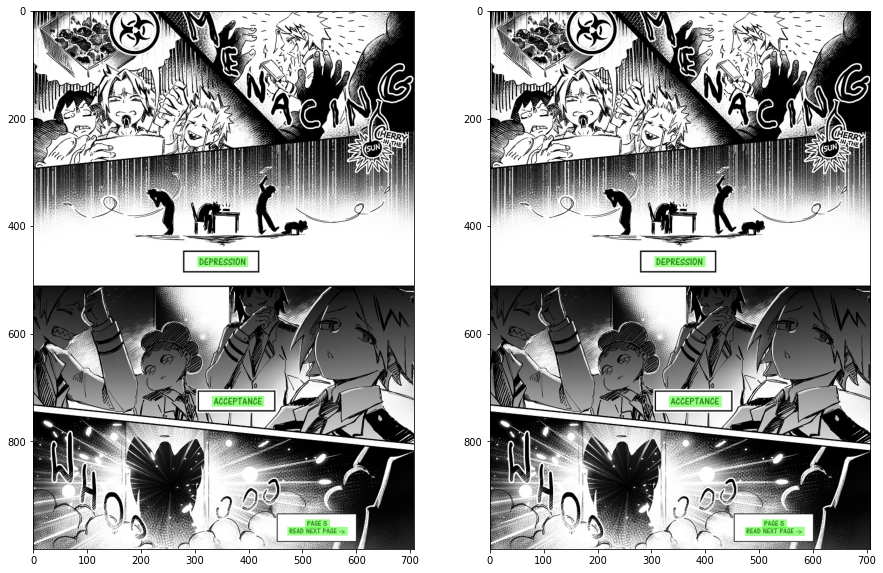

In [29]:
from comic_ocr.utils import image_with_annotations
from comic_ocr.utils.ploting import show_images

def image_with_annotated_lines(model, image):
    paragraph_locations = model.locate_lines(image)
    return image_with_annotations(image, paragraph_locations)


show_images([
    image_with_annotated_lines(model, dataset_example.get_image(0)),
    image_with_annotated_lines(default_model, dataset_example.get_image(0))
])


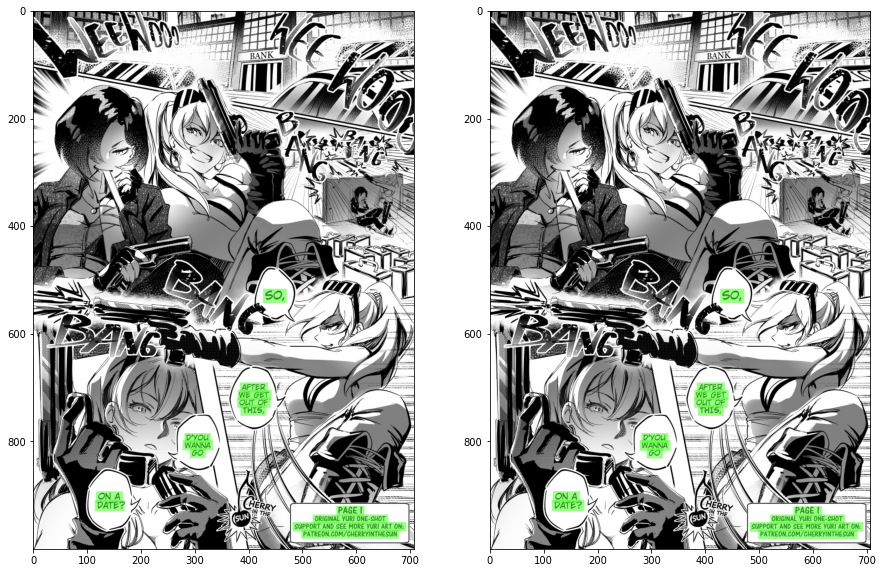

In [30]:
show_images([
    image_with_annotated_lines(model, dataset_example.get_image(1)),
    image_with_annotated_lines(default_model, dataset_example.get_image(1))
])

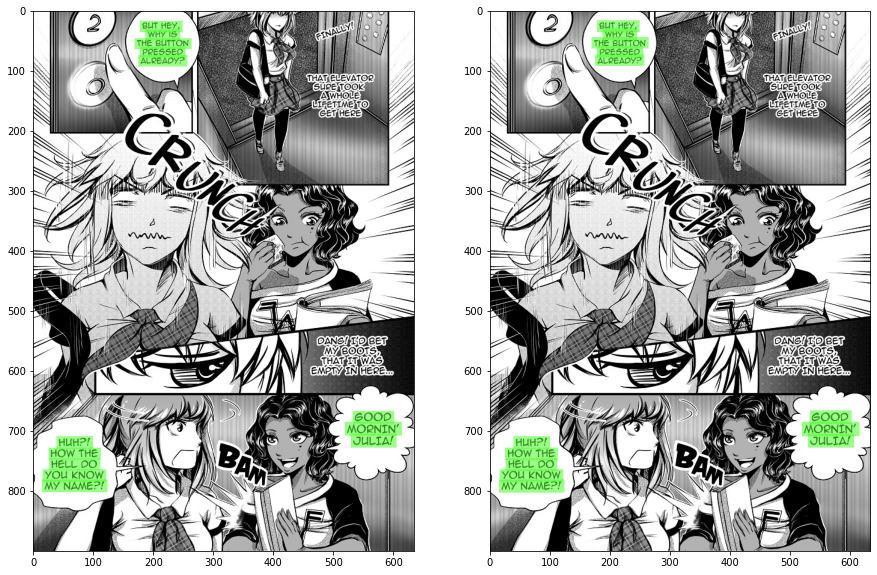

In [31]:
show_images([
    image_with_annotated_lines(model, dataset_example.get_image(2)),
    image_with_annotated_lines(default_model, dataset_example.get_image(2))
])

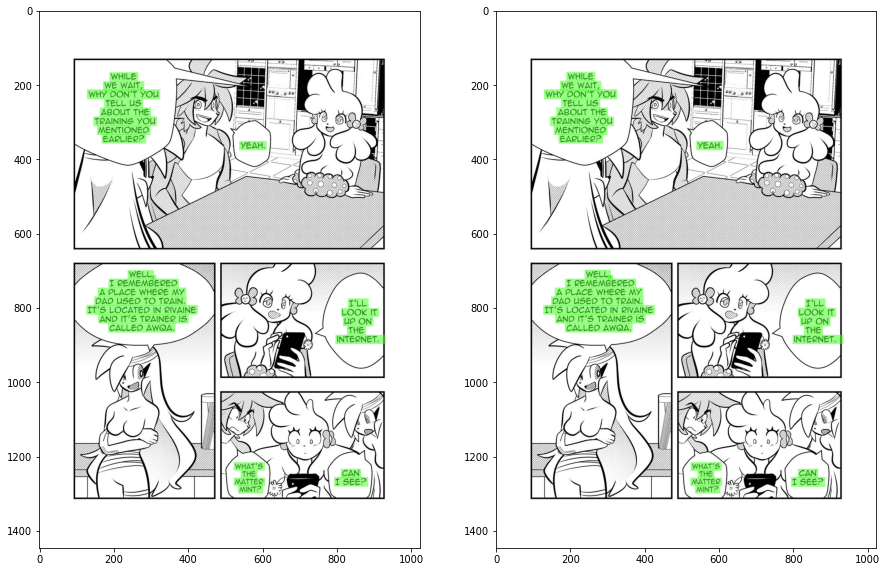

In [37]:
show_images([
    image_with_annotated_lines(model, dataset_example.get_image(3)),
    image_with_annotated_lines(default_model, dataset_example.get_image(3))
])

## Example difficult examples

In [32]:
from comic_ocr.models.localization import train


def show_debug_image_and_output(dataset, index):
    output_char, output_line = model.create_output_marks(dataset.get_image(index))
    show_images([
        dataset.get_image(index),
        dataset.get_mask_char(index),
        output_char,
    ])
    show_images([
        dataset.get_image(index),
        dataset.get_mask_line(index),
        output_line,
    ])

In [33]:
loss_criterion_for_char = WeightedBCEWithLogitsLoss(weight=1.0).to(device)
loss_criterion_for_line = WeightedDiceLoss(weight=0.1).to(device)


[(i, loss) for i, loss in enumerate(train.compute_loss_for_each_sample(model, dataset_example, 
                                                                       loss_criterion_for_char=loss_criterion_for_char,
                                                                       loss_criterion_for_line=loss_criterion_for_line))]

[(0, tensor([0.0193], grad_fn=<AddBackward0>)),
 (1, tensor([0.0204], grad_fn=<AddBackward0>)),
 (2, tensor([0.0158], grad_fn=<AddBackward0>)),
 (3, tensor([0.0119], grad_fn=<AddBackward0>)),
 (4, tensor([0.0140], grad_fn=<AddBackward0>))]

In [36]:
loss_criterion_for_char = WeightedBCEWithLogitsLoss(weight=1.0).to(device)
loss_criterion_for_line = WeightedDiceLoss(weight=0.1).to(device)


[(i, loss) for i, loss in enumerate(train.compute_loss_for_each_sample(model, dataset_annotated, 
                                                                       loss_criterion_for_char=loss_criterion_for_char,
                                                                       loss_criterion_for_line=loss_criterion_for_line))]

[(0, tensor([0.0349], grad_fn=<AddBackward0>)),
 (1, tensor([0.0226], grad_fn=<AddBackward0>)),
 (2, tensor([0.0378], grad_fn=<AddBackward0>)),
 (3, tensor([0.0165], grad_fn=<AddBackward0>)),
 (4, tensor([0.0144], grad_fn=<AddBackward0>)),
 (5, tensor([0.0134], grad_fn=<AddBackward0>)),
 (6, tensor([0.0222], grad_fn=<AddBackward0>)),
 (7, tensor([0.0208], grad_fn=<AddBackward0>)),
 (8, tensor([0.0190], grad_fn=<AddBackward0>)),
 (9, tensor([0.0214], grad_fn=<AddBackward0>)),
 (10, tensor([0.0178], grad_fn=<AddBackward0>)),
 (11, tensor([0.0119], grad_fn=<AddBackward0>)),
 (12, tensor([0.0125], grad_fn=<AddBackward0>)),
 (13, tensor([0.0193], grad_fn=<AddBackward0>)),
 (14, tensor([0.0204], grad_fn=<AddBackward0>)),
 (15, tensor([0.0158], grad_fn=<AddBackward0>)),
 (16, tensor([0.0330], grad_fn=<AddBackward0>)),
 (17, tensor([0.0233], grad_fn=<AddBackward0>)),
 (18, tensor([0.0186], grad_fn=<AddBackward0>)),
 (19, tensor([0.0222], grad_fn=<AddBackward0>)),
 (20, tensor([0.0182], grad_fn

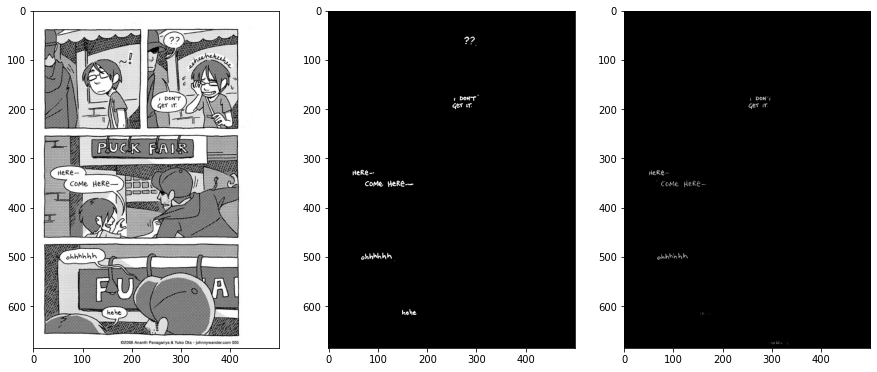

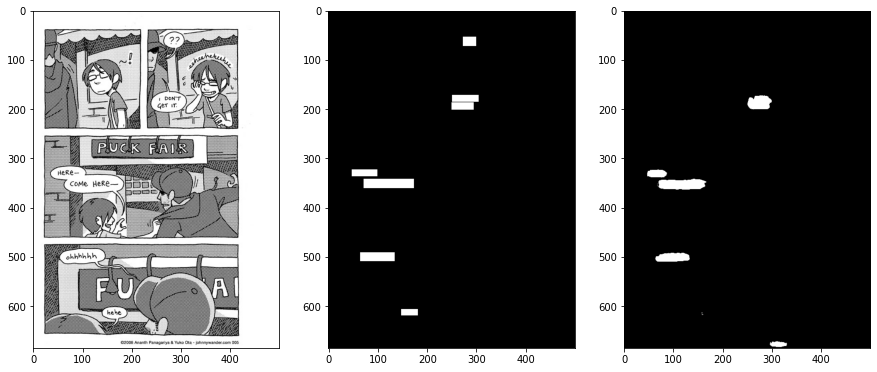

In [35]:
show_debug_image_and_output(dataset_annotated, 0)